<a href="https://colab.research.google.com/github/Asdqwe258/Asdqwe258.github.io/blob/main/Final_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
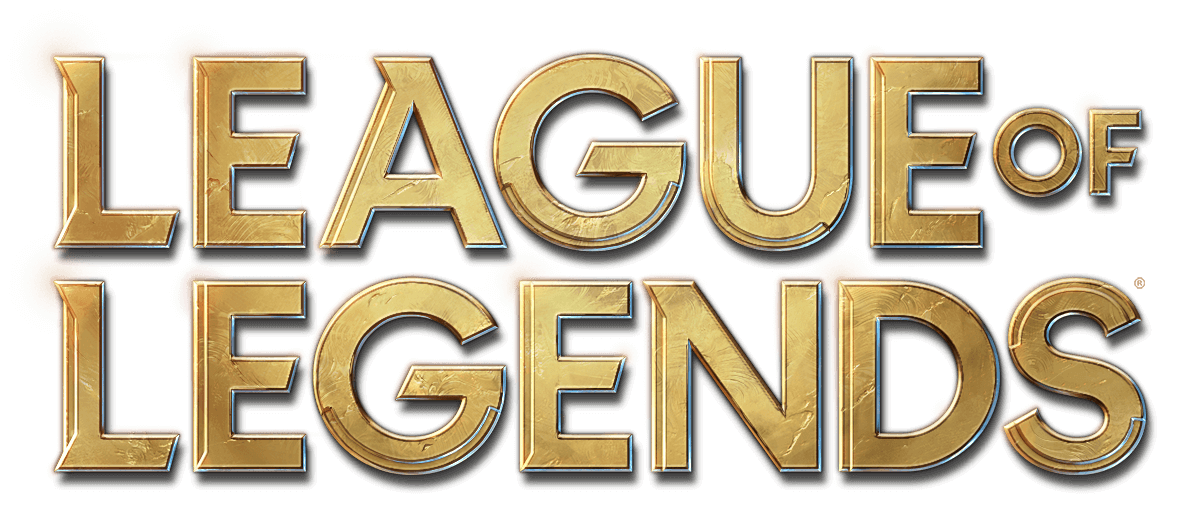
### What is League
League of Legends is a competetive 5v5 MOBA created and developed by Riot Games. It is one of the most popular and highest grossing games of all time, with an estimated 180 million players and an estimated revenue of 1.75 billion dollars in the year 2020. One of the main driving factors behind the game's popularity is the professional scene. Riot sponsors tournaments to have some of the best players compete for prize pools up to $2,225,000.[(source)](https://liquipedia.net/leagueoflegends/World_Championship/2021)
### How is League Played?
The main goal in League of Legends is to destroy the enemy nexus. Players control units on the battlefield called "champions" and seek to defeat their opponents in battle, and acquire objectives that will lead their team closer to victory. There are many factors that go into playing the game most effectively, such as gold, kills, vision score, and even dragons defeated. All of these need to be carefully considered when players make their choices in the game.
### Can we predict the outcome of matches based on given data?
Riot Games has their own [API](https://developer.riotgames.com/) which conviently tracks a large amount of statistics that occur within the game. This API contains data for nearly every meaningful point of data, and contains within it the match history for every game going all the way back to 2013. For our project, we will be looking into the matches of professional players and see if it is possible to accurately predict the outcome of matches by looking at the performance of a single player within a game.


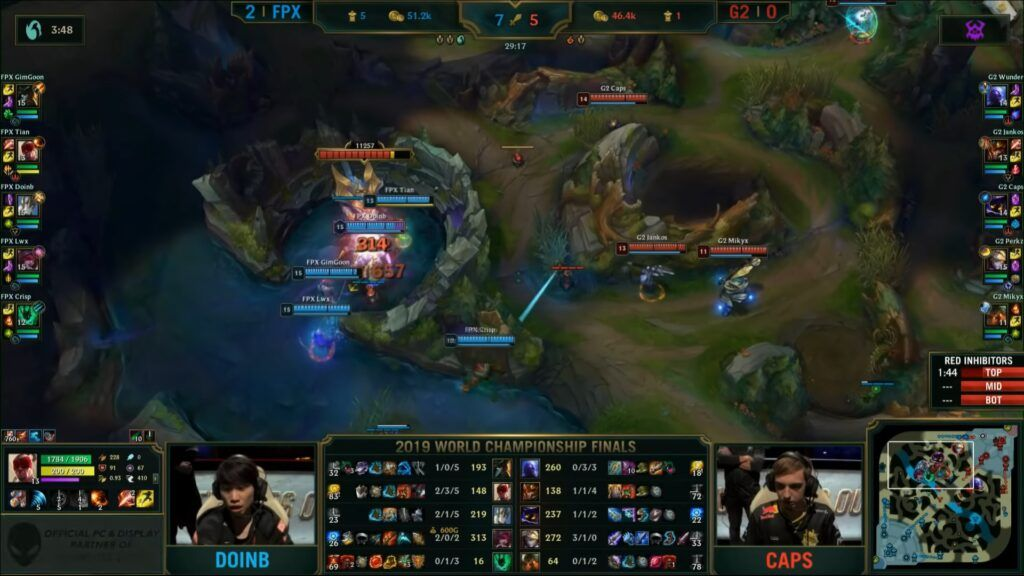

# Data Wrangling
### Where are we getting data?
The Riot API contains data for every game created by Riot, and has data for every region that they support in the entire world. Naturally, we do not want most of this data, so our first step is to filter out what we don't want. For our purposes, we will be collecting match data from specific professional Korean players on the team [T1](https://t1.gg/).
### What data points are we getting?
The Riot API may be able to provide data on nearly every metric imaginable, but we will still need to interpret this data to have them be useful for prediction. To this end, we will be normalizing relavant data. The statistics that we plan to consider for prediction will be:


*   Kills/Minute
*   Assists/Minute
*   Deaths/Minute
*   Gold/Minute
*   Damage/Minute
*   Team Role
*   Vision Score/Minute

There are many statistics that we chose not to include. For this project, we are only focusing on the impact that a single player has on the chances of victory. As such we need to strategically limit what we choose so that we avoid overfitting for one, and to avoid stats that can be highly affected by other players in the game.

### Why focus on these data points?
We chose these data points because we believe that these are the most indicative metrics that are related to a player's win/loss state. Kills/minute, Assists/minute, and gold/minute are all related. This is due to how killing a player works in League of Legends. When one player kills another, that player gains 300 gold, assisting players gain 150 gold split among how many people assisted, and the person who died must respawn after a duration that dramatically increases the longer the game goes on. Gold/minute is important because gold is required for buying items, which increase the strength of your character. Damage/minute is useful for gauging how much a player was able to contribute to damaging the enemy, which is a better metric for displaying how effective a player was, unlike kills/minute. Team position is important because different positions will affect the expected values of all the other metrics we are tracking. Vision score/minute is an indicator to how much information a player was able to acquire by themselves. League of Legends has a fog of war mechanic, so players who are able to uncover more information are able to let their team make more educated decisions.


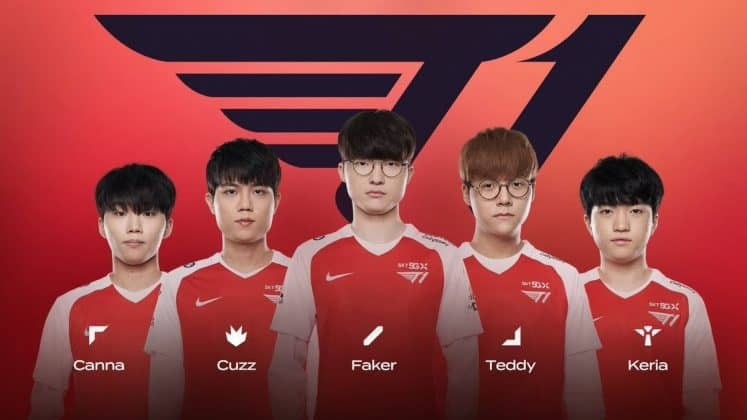

#Beginning Data Wrangling

We will be using the Riot API through [riotwatcher](https://riot-watcher.readthedocs.io/en/latest/), as well as [seaborn](https://seaborn.pydata.org/), [scikit-learn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/), [matplotlib](https://matplotlib.org/stable/users/index.html), and more.


In [22]:
!pip install riotwatcher -q
!pip install sklearn -q
!pip install seaborn -q
!pip install statsmodels -q

from riotwatcher import LolWatcher, ApiError
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf

import requests as req
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import time
# global variables
api_key = 'RGAPI-bb5026d8-f7d1-4ce6-b143-bf2c0145bbda'
watcher = LolWatcher(api_key)
my_region = 'kr'
number_of_matches = 50
SKT = ['티원 탑', 'T1 jg test', 'Hide on bush', 'T1 Gumayusi', 'Yukarlna']

Watcher allows us to interface directly with the Riot API in our code more easily. For the data we chose to train on, we chose the Korean professional gaming team T1. There is no real signfigance in choosing this team over another one, they were chosen because they are a popular team and have competent players who are proficient at the game. We took the latest 50 matches from the players in their main roster for training data.


In [23]:
version = watcher.data_dragon.versions_for_region(my_region)
champion_data = watcher.data_dragon.champions(version['n']['champion'])['data']

We make sure that we possess data that is up to date and accurate. League of Legends is a game that is updated frequently with balance adjustments, so the correlation between certain stats and a victory can be affected.


In [24]:
matches_by_user = []
for user_id in SKT:
  user = watcher.summoner.by_name(my_region, user_id)
  matches = watcher.match.matchlist_by_puuid('Asia', user['puuid'], count= number_of_matches)
  matches_by_user.append(matches)

matches_by_user = [item for sublist in matches_by_user for item in sublist]
matches_by_user = np.unique(np.array(matches_by_user))

We collect the raw data from the Riot API. We must obtain the id for each player in order to collect their match data. We then put them all into an array to manipulate later.


In [ ]:
column_names = ['game_duration','kills', 'assists', 'deaths','Champion','perks','goldEarned','goldSpent','totalDamageDealtToChampions','visionScore', 'teamPosition']
all_matches = {}
temp = None
focused_matches = []
all_matches_df = []
for match in matches_by_user:
  mdata = watcher.match.by_id('Asia', match)
  temp = mdata
  single_match = []
  for p in mdata['info']['participants']:
    player_row = {} 
    player_row['summonerName'] = p['summonerName']
    player_row['champion'] = p['championName']
    player_row['kills'] = p['kills']
    player_row['kpm'] = p['kills']/(p['timePlayed']/60)
    player_row['assists'] = p['assists']
    player_row['apm'] = p['assists']/(p['timePlayed']/60)
    player_row['deaths'] = p['deaths']
    player_row['depm'] = p['deaths']/(p['timePlayed']/60)
    player_row['goldEarned'] = p['goldEarned']
    player_row['gpm'] = p['goldEarned']/(p['timePlayed']/60)
    player_row['goldSpent'] = p['goldSpent']
    player_row['totalDamageToChampions'] = p['totalDamageDealtToChampions']
    player_row['dpm'] = p['totalDamageDealtToChampions']/(p['timePlayed']/60)
    player_row['visionScore'] = p['visionScore']
    player_row['vpm'] = p['visionScore']/(p['timePlayed']/60)
    player_row['teamPosition'] = p['teamPosition']
    player_row['timePlayed'] = p['timePlayed']
    player_row['tags'] = champion_data[p['championName']]['tags']
    player_row['win'] = p['win']
    all_matches_df.append(player_row)
    single_match.append(player_row)
  all_matches[match] = pd.DataFrame(single_match)

all_matches_df = pd.DataFrame(all_matches_df)
tags_list = pd.DataFrame(all_matches_df['tags'].tolist()).stack()
tags_list = pd.get_dummies(tags_list).sum(level=0)
all_matches_df = pd.concat([all_matches_df, tags_list], axis = 1)
focused_matches_df = all_matches_df[all_matches_df.summonerName.isin(SKT)]
focused_matches_df.head()

We are collecting the statistics of all the players that were present in the games with our target players. We take the ones that we assume are correlated to win ratio. We will be narrowing these down later. For some of these, it is required that we normalize them, so the data does not become skewed due to variation in game length. A longer game length naturally means that more activity will happen in the game, leading to higher numbers.


# Data Visualization

### Visualising differences in champion roles

In [ ]:
champions = pd.unique(all_matches_df["champion"])
positions = pd.unique(all_matches_df["teamPosition"])
types = pd.unique(all_matches_df["tags"].explode())
metrics = ["kpm", "dpm", "depm", "gpm", "apm", "vpm"]
exploded_tags = all_matches_df.explode('tags')


To better understand differences between champion types, we will visualize the data of each metric we are testing across different champion classes. From this we will be able to see which champion classes excel in which areas, and also how important each stat is for the class in achieving victory.


In [ ]:
fig, ax = plt.subplots(len(metrics), 1,figsize=(5,9))
for idx, metric in enumerate(metrics):
  sb.barplot(x="tags", y=metric, estimator=np.mean, data=exploded_tags, ax=ax[idx], hue="win")

The visualisation of this data allows us to draw many interesting conclusions. In general, we can see how important a stat is by comparing the difference between the stat when the player wins and the stat when a player loses. From a glance, among all champion classes, having a high amount of kills per minute is highly correlated with achieving a victory, with the win bar nearly double of the loss bar in all champion classes.


In the damage per minute graph, even though marksmen output the most damage out of all the classes, the damage output of a marksman seems to have little effect on their win ratio. 



In the assists per minute graph, supports have a very high correlation with a high number of assists and victory. However, it important to remember that correlation in no way implies causation. It is more likely the case that the winning game state allows for more opportunities for the support to acquire assists, as there will be more kills made by their team. 

In the deaths per minute graph, deaths have a very high correlation with losing in all of the champion classes, and has a higher disparity between winning and losing than all the other stats. This suggests that deaths/minute is one of the most important stats that can predict a win or loss.



The data for vision score is especially interesting, as we can see how important it is for certain champion classes to place wards. This specific conclusion will not be useful for the purposes of this project, but it is one that is very applicable in other areas.

### Visualizing Relations

In [ ]:
def norm(cat, df):
  df[cat] = (df[cat] - df[cat].mean())/df[cat].std()
metrics = ["kpm", "gpm", "dpm", "depm", "apm", "vpm"]
correlation_points = all_matches_df[metrics]
#sb.pairplot(correlation_points.sample(frac=1/5), diag_kind="kde")

In [ ]:
corr_matrix = correlation_points.corr()
masked = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
sb.heatmap(corr_matrix, vmin=-1, vmax=1, mask=masked, annot=True, cmap='BrBG')

Here we are comparing the datapoints of each metric we are examining to find correlations. From our method, one limitation that we have is that we can only easily determine linear relationships by looking at it. Any relationship that may have a higher dimentionality will be harder to detect with our eyes alone.We can see that gpm(Gold per Minute), dpm(Damage per Minute), and kpm(Kills per Minute) have a relatively strong correlation with each other. This makes sense in the context of the game as acquiring kills rewards you with gold, having more gold allows you to buy items to deal more damage, and having more damage allows you to get more kills. 

Vpm(Vision score per Minute) and apm(Assists per Minute) have a high correlation as well. This can be explained by the fact that the support role will naturally acquire more vision score than the other roles in the game due to how the game systems work, and supports's toolkits being more inclined towards helping their teammates. 

Depm(Deaths per minute is unique in that it has a negative relationship with every other metric in this heatmap. Dying in League of Legends puts you out of the game for a significant amount of time each time you die, so the amount of activity you will be able to have in the game will be reduced. 

These correlations show that the groups of (kpm, dpm, gpm), (apm,vpm) have roughly linear relationships which show that if a player is excelling in one of these areas, it is likely that they are excelling in the others. Our other visualizations have shown that some of these areas affect the chances of victory more than others, so the fact that these heatmaps show such a correlation tells us that winning is not so straightfoward as trying to maximize one of these stats when playing a match. (depm, everything else) has a negative relationship, and our other visualizations show that dying universally does not help to win a game, so avoiding deaths is generally something that all players should look to do.

From the results of our visualization, we chose to exclude dpm and vpm as variables in our predictor. They do not have a strong enough correlation with winning to justify including them and inducing overfitting.

# ML and Testing

### Logistic Regression
In order to work with our datasets, we need to add one hot encodings to teamPosition and the champion type. We can do a simple dummy encoding to both of these. In addition, we need to be able to train the data and test it, so we do a train test split approach with 40% of data being allocated to testing and the rest to training.

In [ ]:
ml_points = all_matches_df[[ "win", "kpm", "gpm", "apm", "depm","Assassin", "Fighter", "Mage", "Marksman", "Support", "Tank"]]
train_matches, test_matches, train_win, test_win = train_test_split(ml_points.iloc[:, 1:], ml_points['win'], test_size=.4)

With our variables decided, we prepare them, the training data, and our testing data for classification. We used a LogisticRegression for classification because it works best for binary dependent classification. The issue with this classifier is the assumption of linearity between dependent and independent variables. Because of the vast quantities of factors that influence a match, it is quite obvious to assume that a pure linear relationship is extremely unlikely.

In [ ]:
mod = LogisticRegression(random_state = 0, max_iter=1000).fit(train_matches, train_win)
accuracy_score(test_win, mod.predict(test_matches))
print(classification_report(test_win, mod.predict(test_matches)))

With a logistic regression, we were able to achieve an average accuracy of 83%. This is not an amazing result, but from this result, we can draw the conclusion that there are more factors required to determine the outcome of a game than just a single player's performance.

### Random Forest Classification

In [ ]:
data = []
for n_depth in range(1,10):
  clf = RandomForestClassifier(max_depth=n_depth, random_state = 0)
  clf.fit(train_matches, train_win)
  acc_train = accuracy_score(train_win, clf.predict(train_matches))
  acc_test = accuracy_score(test_win, clf.predict(test_matches))
  temp = {"n_depth": n_depth, "Train Accuracy": acc_train, "Test Accuracy": acc_test}
  data.append(temp)
data = pd.DataFrame(data)

sb.lineplot(x = "n_depth", y="value", hue="variable", data = pd.melt(data, ["n_depth"]))

This is a visualization of the accuracy of predictions using random forest classifiers with varying depths. From this we can see the best depth to use in order to get the most accurate data. Increasing the depth past 4 only increases the overfitting for the dataset. This is important for us because it helps give us our bounds for our GridSearchCV which we will use to optimize the hyperparameters for the RandomForest.

For this Random Forest Classifier, we use a pipeline for three processes: scaling, reducing dimensions, and creating the RandomForest. The first step is the scaler, which helps normalize the data and removes outliers which may skew data. The second step is to reduce the dimension. We use PCA, which helps reduce the dimensionality of the features we have selected. If we have too many features when training the random forest, we can easily create an overreliance on factors that do not have a true effect in determining the outcome of a game. This can easily create overreliance.

In [ ]:

std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = RandomForestClassifier()
pipe = Pipeline(steps=[('std_slc', std_slc), ('pca', pca), ('dec_tree', dec_tree)])
n_components = list(range(1, train_matches.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6]
params = dict(pca__n_components=n_components, dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)
grid = GridSearchCV(pipe, params, verbose = 1, refit=True)
grid.fit(train_matches, train_win)
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
print(classification_report(test_win, grid.predict(test_matches)))

For this Random Forest, we optimized based on three aspects: the PCA component reduction, the score criteria, and the max_depth. In our run of the trial, we received an optimal score of .82 with pca components of 9, gini, and a depth of 5. (Please note that since this is a RandomForest, rerunning the code may result in different optimized hyperparameters because scoring may change. We set the random state to 0, so it should be similar, but it will slightly vary on rerun). Increasing PCA component may increase the accuracy of the trees by reducing the features that are unimportant, but may also hide hidden intracacies. The depth of the tree affects how well we overfit, and how many choices we may make.

The decision tree may be the best classifier for this case, but is limited in several aspects. It cannot handle too many features very well, and because League has so many different combinations and possibilities of team composition and strategy, it is very difficult to create a better predictor because we lack the ability to introduce these features in this model without creating too much bias. The logistic regressor does on average better because it focuses solely on factors that directly correlate with a win (i.e. a clearer linear correlation with victory). Because of this, the logistic classification may work well on this specific set of data, but may not work better as a true predictor for the global datasets.

We were able to achieve an average accuracy of 82%. While this result is not the best, we can draw a similar conclusion to what we determined from the logistic regression. The win/loss value of a game depends on more than the performance of just a single player.

# Conclusion
We were unable to develop a predictor that achieves a high accuracy by using the stats of individual players as predictors. League of Legends, as a 5v5 team game, requires teamwork and coordination to win. Because of this, although the impact a single player can make on a match can be great, it cannot account for the state of the entire match as a whole. Many other factors come into play during a game of League of Legends, and if we were to take more than what we have into account, we would take away from our original goal of focusing on only one player, and with that many features, overfitting becomes an issue. It is due to these factors that we achieved the accuracy that we did. 

We were also able to discover that many of these personal stats have a high correlation with each other, but not all of these stats are as important as other stats when taking win rate into account. Out of all the stats, Deaths/minute seems to be the most related with the chances of victory. As stated before, Dying in League of Legends means that you are unable to impact the game for an extended period of time. Naturally, if you are unable to prevent the opponents from winning due to being dead, you will lose. 

Overall, League of Legends is a very complex game with many factors that interact with each other in many different ways. For this reason, we believe that an average accuracy of 82% is very good for what we set out to do. We had expected it to be lower, but we failed to take into account the fact that while the indiviual is impacting the state of the game, the state of the game is also affecting the player. For this reason, the indiviual stats of a player reflects how well the team is doinsg as well, to a degree. We hypothesize that players of higher skill will be able to achieve a higher percentage of accuracy if used as testing data, but this is outside the scope of our project.